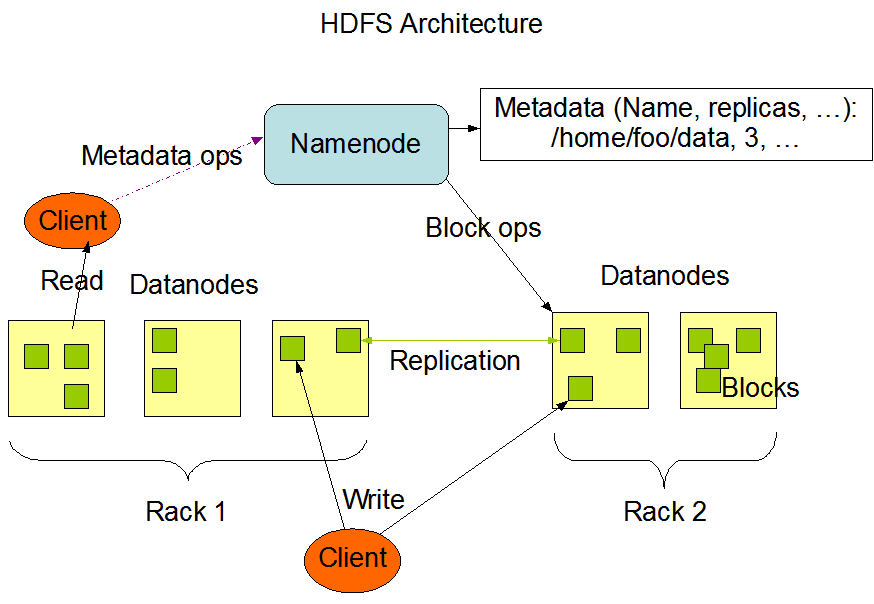

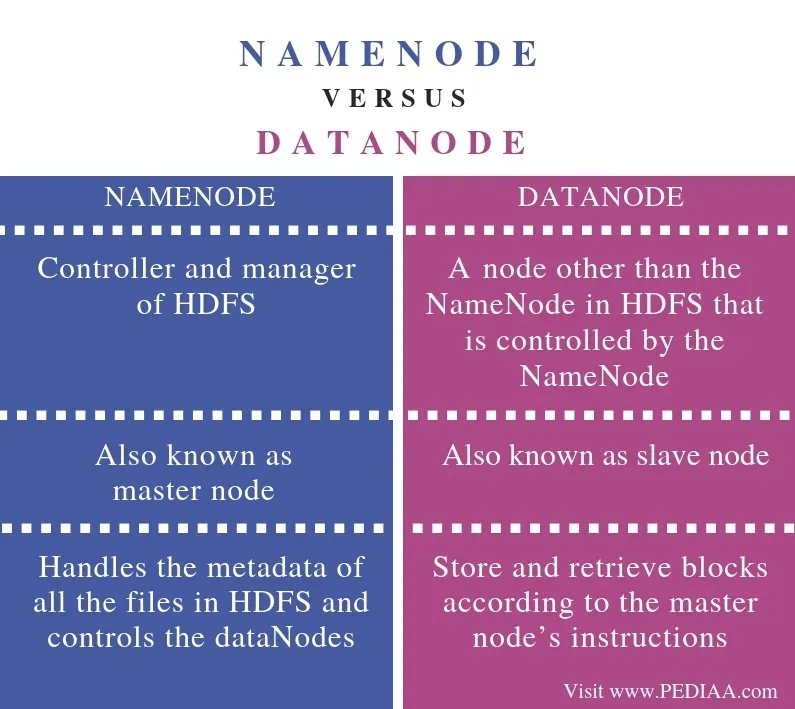

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=4aef41937af2c1696cb9192bbf4f9182ed3029735f74d4b4dd1498c93559700d
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import pyspark

In [ ]:
# Create a Spark Session
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Regression").getOrCreate()

In [ ]:
spark

In [ ]:
salesdf=spark.read.csv('/content/drive/MyDrive/BlackFridaySales/train.csv',
                       inferSchema=True,header=True)

In [ ]:
salesdf.show(5)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|              null|              null|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|              null|              null|    1422|
|100

In [ ]:
from pyspark.sql.functions import isnull, when,count,col

In [ ]:
# Find Missing Values
salesdf.select([count(when(isnull(c),c)).alias(c)
for c in salesdf.columns]).show()

+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|      0|         0|     0|  0|         0|            0|                         0|             0|                 0|            173638|            383247|       0|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+



In [ ]:
salesdf.groupBy('Product_Category_2').count().show()

# Impute with Numeric Missing Code - 999

+------------------+------+
|Product_Category_2| count|
+------------------+------+
|                12|  5528|
|                13| 10531|
|                 6| 16466|
|                16| 43255|
|                 3|  2884|
|                 5| 26235|
|                15| 37855|
|                 9|  5693|
|                17| 13320|
|                 4| 25677|
|                 8| 64088|
|                 7|   626|
|                10|  3043|
|                11| 14134|
|                14| 55108|
|                 2| 49217|
|               999|173638|
|                18|  2770|
+------------------+------+



In [ ]:
salesdf=salesdf.na.fill(value=999,subset=['Product_Category_2'])

In [ ]:
salesdf.groupBy('Product_Category_3').count().show()

+------------------+------+
|Product_Category_3| count|
+------------------+------+
|                12|  9246|
|              null|383247|
|                13|  5459|
|                16| 32636|
|                 6|  4890|
|                 3|   613|
|                 5| 16658|
|                15| 28013|
|                17| 16702|
|                 9| 11579|
|                 4|  1875|
|                 8| 12562|
|                10|  1726|
|                11|  1805|
|                14| 18428|
|                18|  4629|
+------------------+------+



In [ ]:
salesdf=salesdf.na.fill(value=999,subset=['Product_Category_3'])

In [ ]:
salesdf.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



In [ ]:
# How Many Male & female are there?
salesdf.groupBy('Gender').count().show()

+------+------+
|Gender| count|
+------+------+
|     F|135809|
|     M|414259|
+------+------+



In [ ]:
# Average Purchase by Gender
salesdf.groupBy('Gender').mean('Purchase').show()

+------+-----------------+
|Gender|    avg(Purchase)|
+------+-----------------+
|     F|8734.565765155476|
|     M|9437.526040472265|
+------+-----------------+



In [ ]:
# Average Purchase by Age
salesdf.groupBy('Age').mean('Purchase').show()

+-----+-----------------+
|  Age|    avg(Purchase)|
+-----+-----------------+
|18-25|9169.663606261289|
|26-35|9252.690632869888|
| 0-17|8933.464640444974|
|46-50|9208.625697468327|
|51-55|9534.808030960236|
|36-45|9331.350694917874|
|  55+|9336.280459449405|
+-----+-----------------+



In [ ]:
salesdf.select('Purchase').describe().show()

+-------+-----------------+
|summary|         Purchase|
+-------+-----------------+
|  count|           550068|
|   mean|9263.968712959126|
| stddev|5023.065393820575|
|    min|               12|
|    max|            23961|
+-------+-----------------+



In [ ]:
from pyspark.sql.functions import skewness,kurtosis,median

In [ ]:
salesdf.select(skewness('Purchase'),kurtosis('Purchase'),
               median('Purchase')).show()

+------------------+-------------------+----------------+
|skewness(Purchase)| kurtosis(Purchase)|median(Purchase)|
+------------------+-------------------+----------------+
|0.6001383671643392|-0.3383853975360327|          8047.0|
+------------------+-------------------+----------------+



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [ ]:
indexer=[StringIndexer(inputCol=column,outputCol=column+'index').fit(salesdf)
for column in list(set(salesdf.columns)-set(['Purchase',
                                             'User_ID','Product_ID']))]

In [ ]:
pipeline=Pipeline(stages=indexer)
salesdf=pipeline.fit(salesdf).transform(salesdf)

In [ ]:
columnstodrop=['User_ID','Product_ID','Gender','Age','Occupation',
               'City_Category','Stay_In_Current_City_Years','Marital_Status',
               'Product_Category_1','Product_Category_2','Product_Category_3']

In [ ]:
salesdf=salesdf.drop(*columnstodrop)

In [ ]:
from pyspark.ml.feature import RFormula

In [ ]:
RFormula,
formula=RFormula(formula='Purchase~.',featuresCol='features',
                 labelCol='label')

In [ ]:
salesdf=formula.fit(salesdf).transform(salesdf)

In [ ]:
salesdf.select('features','label').show(5)

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[2.0,0.0,6.0,0.0,...| 8370.0|
|[2.0,3.0,6.0,0.0,...|15200.0|
|[2.0,0.0,6.0,0.0,...| 1422.0|
|[2.0,0.0,6.0,0.0,...| 1057.0|
|[1.0,0.0,5.0,0.0,...| 7969.0|
+--------------------+-------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
reg=LinearRegression(featuresCol='features',labelCol='label')

In [ ]:
regmodel=reg.fit(salesdf)

In [ ]:
regmodel.summary.r2adj

0.06356300117930458

In [ ]:
regmodel.summary.rootMeanSquaredError

4860.759869813397

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
tree=DecisionTreeRegressor(featuresCol='features',labelCol='label',
                           maxDepth=8)

In [ ]:
treemodel=tree.fit(salesdf)

In [ ]:
treepredict=treemodel.transform(salesdf)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
rsquare=RegressionEvaluator(predictionCol='prediction',labelCol='label',
                         metricName='r2')

In [ ]:
rmse=RegressionEvaluator(predictionCol='prediction',labelCol='label',
                         metricName='rmse')

In [ ]:
rsquare.evaluate(treepredict)

0.6552517597578954

In [ ]:
rmse.evaluate(treepredict)

2949.303501228663

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
RF=RandomForestRegressor(numTrees=500)

In [ ]:
RFmodel=RF.fit(salesdf)

In [ ]:
RFpredict=RFmodel.transform(salesdf)

In [ ]:
rmse.evaluate(RFpredict)

3133.786094136899